In [1]:
cd ..

/home/ezequiel


In [2]:
cd pyLIMA-env

/home/ezequiel/pyLIMA-env


In [3]:
cd pyLIMA

/home/ezequiel/pyLIMA-env/pyLIMA


In [4]:
import pyLIMA

In [5]:
# importing the necessary libs

%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

from pyLIMA.fits import TRF_fit
from pyLIMA.models import FSPL_model

from pyLIMA.models import pyLIMA_fancy_parameters   # lib that we are interested in
from pyLIMA.outputs import pyLIMA_plots

from pyLIMA import event
from pyLIMA import telescopes

In [6]:
pyLIMA_fancy_parameters.standard_fancy_parameters

{'log_tE': 'tE',
 'log_rho': 'rho',
 'log_separation': 'separation',
 'log_mass_ratio': 'mass_ratio'}

In [7]:
# creating the EVENT

your_event =  event.Event()
your_event.name = 'My event name'

In [8]:
# creating both telescopes: OGLE & LCO - i band filters

data_1 = np.loadtxt('examples/data/Survey_1.dat')
telescope_1 = telescopes.Telescope(name='OGLE',
                                  camera_filter = 'I',
                                  light_curve = data_1.astype(float),
                                  light_curve_names = ['time','mag','err_mag'],
                                  light_curve_units = ['JD','mag','mag'])

data_2 = np.loadtxt('examples/data/Followup_1.dat')
telescope_2 = telescopes.Telescope(name='LCO',
                                  camera_filter = 'I',
                                  light_curve = data_1.astype(float),
                                  light_curve_names = ['time','mag','err_mag'],
                                  light_curve_units = ['JD','mag','mag'])

In [9]:
#appending both created telescopes to the event

your_event.telescopes.append(telescope_1)
your_event.telescopes.append(telescope_2)

In [10]:
# setting our calibration to OGLE

your_event.find_survey('OGLE')

In [11]:
# sanity check

your_event.check_event()

check_event  : Everything looks fine...


In [12]:
# setting the lambda darkening factor to 0.5 to improve fit

your_event.telescopes[0].ld_gamma = 0.5   # can call telescopes via EVENT since both been appended
your_event.telescopes[1].ld_gamma = 0.5

In [13]:
my_pars = {'log_tE': 'tE'}   # changing our tE parameter to log_tE

fspl = FSPL_model.FSPLmodel(your_event,fancy_parameters = my_pars)   # creating the FSPL model 

we will be fitting this model to our data using a Trust Region Reflective (TRF) algorithm. Note that the algorithm does not automatically detect the change of parameter

and using the parameters that we obtained in the previous tutorial: [t0,u0,tE,rho] = [79.9,0.008,10.1,0.023]

In [14]:
guess_parameters = [79.9,0.008,np.log(10.1),0.023]   # note the log function where needed

In [15]:
from pyLIMA.fits import TRF_fit
my_fit = TRF_fit.TRFfit(fspl)
my_fit.model_parameters_guess = guess_parameters   # inserting the modified/needed parameters

my_fit.fit()   # running the algorithm

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [79.9, 0.008, 2.312535423847214, 0.023, 106.38023110721669, 2606.0644436503712, 106.38023110721669, 2606.0644436503712]
fit  : Trust Region Reflective fit SUCCESS
best_model: [79.93105455708249, 0.0081099409233324, 1.0050425553150024, 0.02264501404625395, 2915.0395775174816, 210.81034380364378, 2915.0395776154646, 210.81034368831806]  chi2: 7681.7870449259935


In [16]:
my_fit.fit_parameters

OrderedDict([('t0', [0, (1.0, 182.32999999999993)]),
             ('u0', [1, (0.0, 1.0)]),
             ('log_tE', [2, array([-1.     ,  2.69897])]),
             ('rho', [3, (5e-05, 0.05)]),
             ('fsource_OGLE', [4, (0.0, 257268.11445883513)]),
             ('fblend_OGLE', [5, (-257268.11445883513, 257268.11445883513)]),
             ('fsource_LCO', [6, (0.0, 257268.11445883513)]),
             ('fblend_LCO', [7, (-257268.11445883513, 257268.11445883513)])])

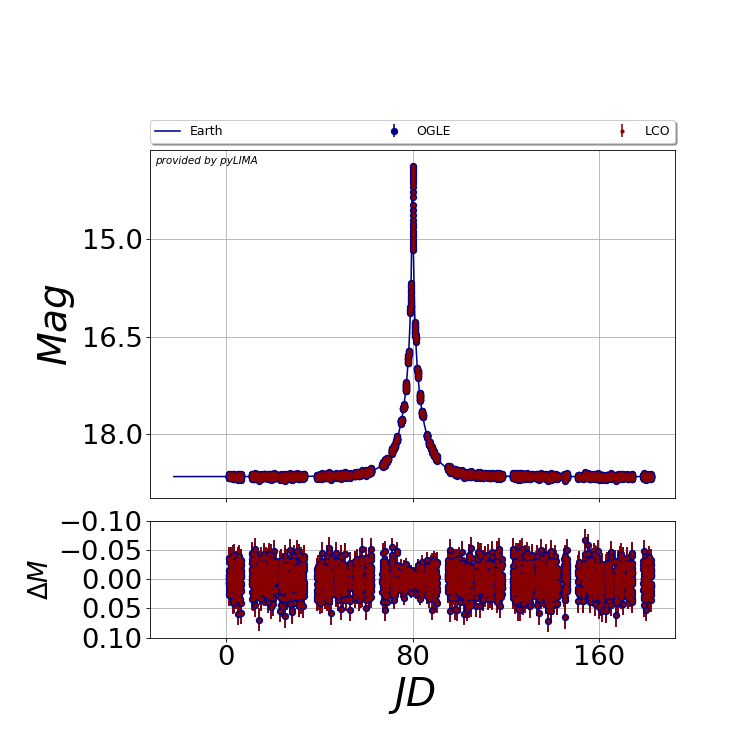

In [17]:
pyLIMA_plots.plot_lightcurves(fspl,my_fit.fit_results['best_model'])
plt.show()

we will now attempt to defined t_star = rho*tE and use log_rho = log(rho) (i.e. two modifications)

a log_rho definition is already provided by the package but we will need to define t_star

In [18]:
def t_star(x):
    return x.rho * x.tE

setattr(pyLIMA_fancy_parameters, 't_star',t_star)

In [19]:
def tE(x):
    return x.t_star/10**(x.log_rho)

setattr(pyLIMA_fancy_parameters,'tE',tE)

In [20]:
dir(pyLIMA_fancy_parameters)   # a success at the bottom

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_t0_to_t_center',
 '_t_center_to_t0',
 '_u0_to_u_center',
 '_u_center_to_u0',
 'log_mass_ratio',
 'log_rho',
 'log_separation',
 'log_tE',
 'mass_ratio',
 'np',
 'rho',
 'separation',
 'standard_fancy_parameters',
 'tE',
 't_star']

In [21]:
my_pars2 = {'log_rho':'rho','t_star':'tE'}   # defining the changes for both needed parameters
fspl2 = FSPL_model.FSPLmodel(your_event, fancy_parameters  = my_pars2)

In [22]:
guess_parameters2 = [79.9,0.008,10.1*0.023,np.log(0.023)]   # inserting the changed parameters as should be defined

In [23]:
my_fit2 = TRF_fit.TRFfit(fspl2)
my_fit2.model_parameters_guess = guess_parameters2
my_fit2.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [79.9, 0.008, 0.23229999999999998, -3.7722610630529876, 28.961811316813503, 2326.012579381475, 28.961811316813503, 2326.012579381475]
fit  : Trust Region Reflective fit SUCCESS
best_model: [79.95727469562883, 0.009629687363743636, 0.007325396850612061, -3.1233048572801354, 3093.7734073672473, 34.71444489103129, 3093.773381201215, 34.71447730699739]  chi2: 12567.960968344974


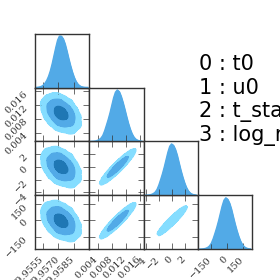

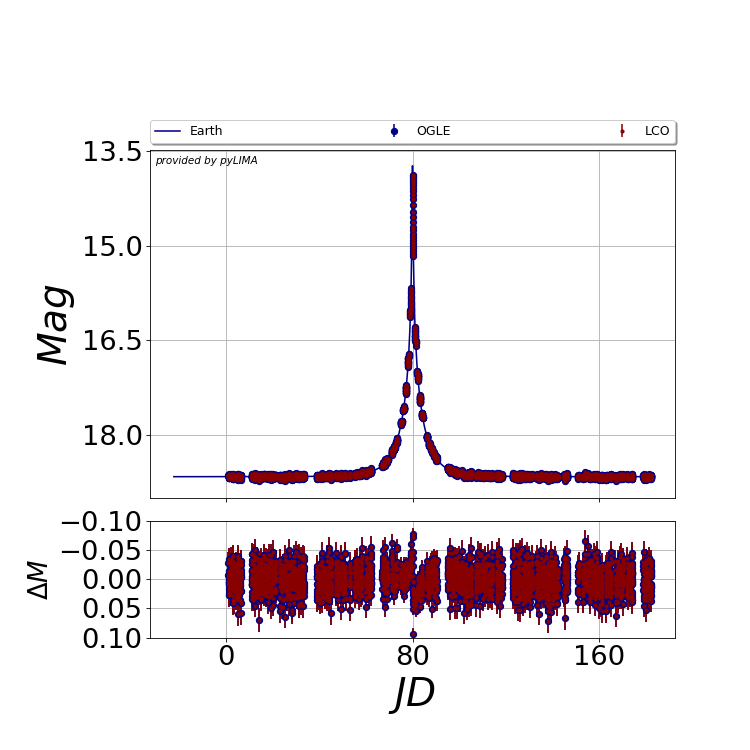

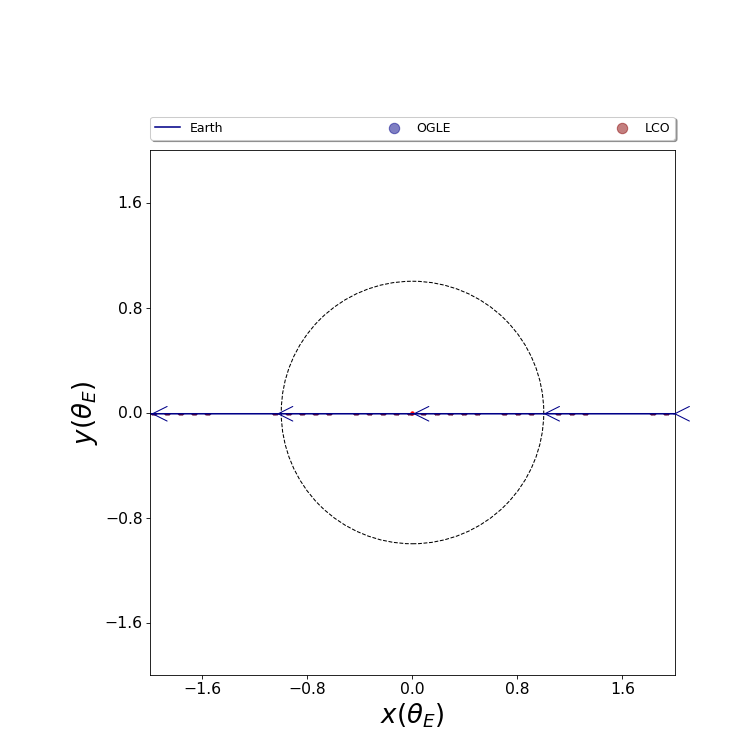

In [25]:
my_fit2.fit_outputs()
plt.show()

In [26]:
print('fit results:',my_fit2.fit_results['best_model'])
print("chi2:",my_fit2.fit_results['chi2'])

fit results: [79.95727469562883, 0.009629687363743636, 0.007325396850612061, -3.1233048572801354, 3093.7734073672473, 34.71444489103129, 3093.773381201215, 34.71447730699739]
chi2: 12567.960968344974


In [28]:
my_fit2.fit_parameters.key()